# Draw a track map with numbered corners

In [2]:
import sys
import fastf1
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
from common import Config

In [3]:
fastf1.Cache.enable_cache(Config.FASTF1_CACHE_DIR)
fastf1.set_log_level('WARNING')

In [4]:
session = fastf1.get_session(2024, 'Saudi Arabia', 'Q')
session.load()

logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)


In [5]:
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


Define a helper function for rotating points around the origin of the coordinate system.

The matrix `[[cos, sin], [-sin, cos]]` is called a rotation matrix.

By matrix multiplication of the rotation matrix with a vector `[x, y]`, a new rotated vector `[x_rot, y_rot]` is obtained.

In [9]:
def rotate(xy, *, angle):
    rot_mat = np.array(
        [[np.cos(angle), np.sin(angle)],
         [-np.sin(angle), np.cos(angle)]]
    )
    return np.matmul(xy, rot_mat)

Get the coordinates of the track map from the telemtry of the lap and rotate the coordinates using the rotation from `circuit_info`
so that the track map is oriented correctly. After that, plot the rotated track map.

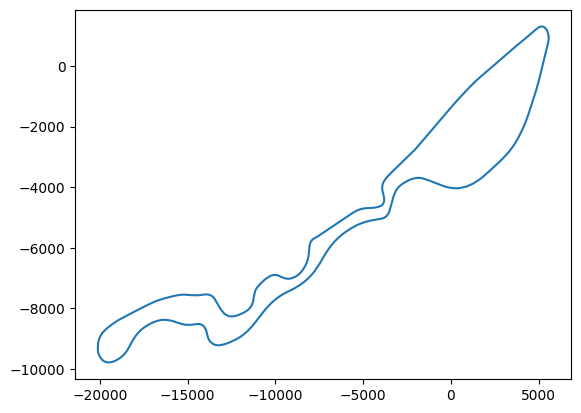

In [13]:
# Get an array of shape [n, 2] where n is the number of points andt he second axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

Finally, the corner markers are plotted.

To plot the numbers next to the track, an offset vector that poinst straight up is defined. This offset vector is then
rotated by the angle that is given for each corner marker. A line an circular bubble are drawn and the corner marker text
is printed inside the bubble.

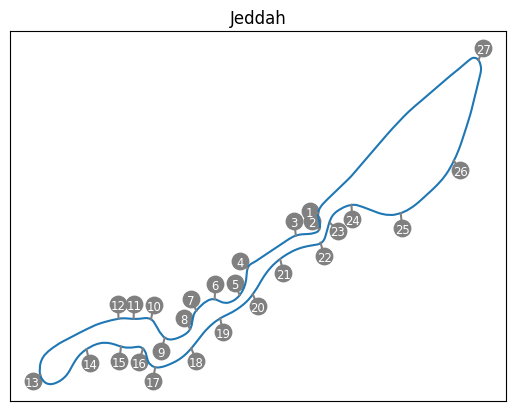

In [20]:
offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# First, plot the track layout
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

# Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"
    
    # Convert the angle from degrees to radian
    offset_angle = corner['Angle'] / 180 * np.pi
    
    # Rotate the offset vector so that it points sideways from the track
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)
    
    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y
    
    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)
    
    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)
    
    # Draw a circle next to the track
    plt.scatter(text_x, text_y, color='grey', s=140)
    
    # Draw a line from the track to this circle
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    
    # Finally, print the corner number inside the circle
    plt.text(text_x, text_y, txt, ha='center', va='center_baseline', size='small', color='white')
    
plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
# plt.axis('equal')
plt.show()